# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. 


## Pretrained MobileNet

We'll be using a pretrained network from https://codelabs.developers.google.com/codelabs/tensorflow-for-poets. 

## Result

Similarly as using "Tensorflow for poets" plugging MobileNet instead of VGG16 produces poor results. Just ~15% accuracy.
It seams that after retraining model finetuning might help. It seams that differenly from VGG in MobileNet some metadata is truncated before suggested bottleck layer ('MobilenetV1/Predictions/Reshape:0').

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [3]:
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $244 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [4]:
import os

import numpy as np
import tensorflow as tf

In [5]:
data_dir = 'food_images/cid11_max2048/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

print (classes)

['20', '18', '0', '3', '24', '1', '5', '6', '11', '17', '16', '8', '23', '21', '10', '9', '15', '12', '19', '13', '2', '7', '14', '4', '22']


In [6]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 1
codes_list = []
labels = []
batch = []

codes = None

In [7]:
from tensorflow.python.platform import gfile
from six.moves import urllib
import sys
import tarfile

model_dir = '/tmp/recipenet'

def create_model_graph(model_info):
    """
    Creates a graph from saved GraphDef file and returns a Graph object.

    Args:
        model_info: Dictionary containing information about the model architecture.

    Returns:
        Graph holding the trained Inception network, and various tensors we'll be
        manipulating.
    """
    with tf.Graph().as_default() as graph:
        model_path = os.path.join(model_dir, model_info['model_file_name'])
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            bottleneck_tensor, resized_input_tensor = (tf.import_graph_def(
              graph_def,
              name='',
              return_elements=[
                  model_info['bottleneck_tensor_name'],
                  model_info['resized_input_tensor_name'],
              ]))
    return graph, bottleneck_tensor, resized_input_tensor


def create_model_info(architecture):
    """Given the name of a model architecture, returns information about it.

    There are different base image recognition pretrained models that can be
    retrained using transfer learning, and this function translates from the name
    of a model to the attributes that are needed to download and train with it.

    Args:
        architecture: Name of a model architecture.

    Returns:
        Dictionary of information about the model, or None if the name isn't
        recognized

    Raises:
        ValueError: If architecture name is unknown.
    """
    architecture = architecture.lower()
    if architecture == 'inception_v3':
        # pylint: disable=line-too-long
        data_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
        # pylint: enable=line-too-long
        bottleneck_tensor_name = 'pool_3/_reshape:0'
        bottleneck_tensor_size = 2048
        input_width = 299
        input_height = 299
        input_depth = 3
        resized_input_tensor_name = 'Mul:0'
        model_file_name = 'classify_image_graph_def.pb'
        input_mean = 128
        input_std = 128
    elif architecture.startswith('mobilenet_'):
        parts = architecture.split('_')
        if len(parts) != 3 and len(parts) != 4:
            tf.logging.error("Couldn't understand architecture name '%s'",
                       architecture)
            return None
        version_string = parts[1]
        if (version_string != '1.0' and version_string != '0.75' and
            version_string != '0.50' and version_string != '0.25'):
            tf.logging.error(
                """"The Mobilenet version should be '1.0', '0.75', '0.50', or '0.25',
                but found '%s' for architecture '%s'""",
                version_string, architecture)
            return None
        size_string = parts[2]
        if (size_string != '224' and size_string != '192' and
            size_string != '160' and size_string != '128'):
            tf.logging.error(
                """The Mobilenet input size should be '224', '192', '160', or '128',
     but found '%s' for architecture '%s'""",
                size_string, architecture)
            return None
        if len(parts) == 3:
            is_quantized = False
        else:
            if parts[3] != 'quantized':
                tf.logging.error(
                    "Couldn't understand architecture suffix '%s' for '%s'", parts[3],
                    architecture)
                return None
            is_quantized = True
        data_url = 'http://download.tensorflow.org/models/mobilenet_v1_'
        data_url += version_string + '_' + size_string + '_frozen.tgz'
        bottleneck_tensor_name = 'MobilenetV1/Predictions/Reshape:0'
        bottleneck_tensor_size = 1001
        input_width = int(size_string)
        input_height = int(size_string)
        input_depth = 3
        resized_input_tensor_name = 'input:0'
        if is_quantized:
            model_base_name = 'quantized_graph.pb'
        else:
            model_base_name = 'frozen_graph.pb'
            model_dir_name = 'mobilenet_v1_' + version_string + '_' + size_string
            model_file_name = os.path.join(model_dir_name, model_base_name)
            input_mean = 127.5
            input_std = 127.5
    else:
        tf.logging.error("Couldn't understand architecture name '%s'", architecture)
        raise ValueError('Unknown architecture', architecture)

    return {
      'data_url': data_url,
      'bottleneck_tensor_name': bottleneck_tensor_name,
      'bottleneck_tensor_size': bottleneck_tensor_size,
      'input_width': input_width,
      'input_height': input_height,
      'input_depth': input_depth,
      'resized_input_tensor_name': resized_input_tensor_name,
      'model_file_name': model_file_name,
      'input_mean': input_mean,
      'input_std': input_std,
    }


def maybe_download_and_extract(data_url):
    """Download and extract model tar file.

    If the pretrained model we're using doesn't already exist, this function
    downloads it from the TensorFlow.org website and unpacks it into a directory.

    Args:
        data_url: Web location of the tar file containing the pretrained model.
    """
    dest_directory = model_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = data_url.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' %
                           (filename,
                            float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        tf.logging.info('Successfully downloaded', filename, statinfo.st_size,
                        'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def add_jpeg_decoding(input_width, input_height, input_depth, input_mean,
                      input_std):
    """Adds operations that perform JPEG decoding and resizing to the graph..

    Args:
    input_width: Desired width of the image fed into the recognizer graph.
    input_height: Desired width of the image fed into the recognizer graph.
    input_depth: Desired channels of the image fed into the recognizer graph.
    input_mean: Pixel value that should be zero in the image for the graph.
    input_std: How much to divide the pixel values by before recognition.

    Returns:
    Tensors for the node to feed JPEG data into, and the output of the
      preprocessing steps.
    """
    jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
    decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
    decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    resize_shape = tf.stack([input_height, input_width])
    resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
    resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
    offset_image = tf.subtract(resized_image, input_mean)
    mul_image = tf.multiply(offset_image, 1.0 / input_std)
    return jpeg_data, mul_image
    

model_info = create_model_info('mobilenet_1.0_224')

maybe_download_and_extract(model_info['data_url'])
graph, bottleneck_tensor, resized_image_tensor = (create_model_graph(model_info))

with tf.Session(graph=graph) as sess:
    # Set up all our weights to their initial default values.
    
    jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(
        model_info['input_width'], model_info['input_height'],
        model_info['input_depth'], model_info['input_mean'],
        model_info['input_std'])
    
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            image_path = os.path.join(class_path, file)
            #img = utils.load_image(image_path)
            #batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            image_data = gfile.FastGFile(image_path, 'rb').read()
            resized_input_values = sess.run(decoded_image_tensor,
                                          {jpeg_data_tensor: image_data})
            
            feed_dict = {resized_image_tensor: resized_input_values}
            codes_batch = sess.run(bottleneck_tensor, feed_dict=feed_dict) 
            #batch = []
            print('{} images processed'.format(1))
            
            # Running the batch through the network to get the codes
            #if ii % batch_size == 0 or ii == len(files):
                #images = np.concatenate(batch)

                #feed_dict = {resized_image_tensor: images}
                
                ######
                #  replace vgg.relu6 with bottleneck ouput from mobilenet
                #codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict) 
                #codes_batch = sess.run(bottleneck_tensor, feed_dict=feed_dict) 
                
                # MobileNet: 'MobilenetV1/Predictions/Reshape:0'
                # Inception_v3: 'pool_3/_reshape:0'
                
                #####
                
            # Here I'm building an array of the codes
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                #batch = []
                #print('{} images processed'.format(1))

Starting 20 images
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images processed
1 images pro

KeyboardInterrupt: 

Below I'm running images through the VGG network in batches.

In [15]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [8]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [11]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (38327, 1001) (38327, 25)
Validation shapes (x, y): (4791, 1001) (4791, 25)
Test shapes (x, y): (4791, 1001) (4791, 25)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [12]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [13]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = 1#len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [14]:
saver = tf.train.Saver()

In [24]:
epochs = 300
iteration = 0
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    #ency is a largely ceremonial post, but the president has the power to appoint the country's prime minister after general elections and has an influential voice in politics.saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/300 Iteration: 0 Training loss: 6.82098
Epoch: 1/300 Iteration: 1 Training loss: 2.93390
Epoch: 1/300 Iteration: 2 Training loss: 5.45284
Epoch: 1/300 Iteration: 3 Training loss: 10.36949
Epoch: 1/300 Iteration: 4 Training loss: 13.36753
Epoch: 0/300 Iteration: 5 Validation Acc: 0.0451
Epoch: 1/300 Iteration: 5 Training loss: 0.26362
Epoch: 1/300 Iteration: 6 Training loss: 7.77769
Epoch: 1/300 Iteration: 7 Training loss: 17.44098
Epoch: 1/300 Iteration: 8 Training loss: 16.19529
Epoch: 1/300 Iteration: 9 Training loss: 12.64583
Epoch: 0/300 Iteration: 10 Validation Acc: 0.0292
Epoch: 2/300 Iteration: 10 Training loss: 0.00000
Epoch: 2/300 Iteration: 11 Training loss: 0.00000
Epoch: 2/300 Iteration: 12 Training loss: 0.64143
Epoch: 2/300 Iteration: 13 Training loss: 0.14713
Epoch: 2/300 Iteration: 14 Training loss: 0.00000
Epoch: 1/300 Iteration: 15 Validation Acc: 0.0392
Epoch: 2/300 Iteration: 15 Training loss: 4.54651
Epoch: 2/300 Iteration: 16 Training loss: 0.00000
Epoch:

Epoch: 14/300 Iteration: 138 Training loss: 0.00179
Epoch: 14/300 Iteration: 139 Training loss: 4.18870
Epoch: 13/300 Iteration: 140 Validation Acc: 0.0722
Epoch: 15/300 Iteration: 140 Training loss: 0.00036
Epoch: 15/300 Iteration: 141 Training loss: 0.00028
Epoch: 15/300 Iteration: 142 Training loss: 0.00111
Epoch: 15/300 Iteration: 143 Training loss: 0.00419
Epoch: 15/300 Iteration: 144 Training loss: 0.00015
Epoch: 14/300 Iteration: 145 Validation Acc: 0.0735
Epoch: 15/300 Iteration: 145 Training loss: 0.00000
Epoch: 15/300 Iteration: 146 Training loss: 0.00001
Epoch: 15/300 Iteration: 147 Training loss: 0.00001
Epoch: 15/300 Iteration: 148 Training loss: 0.00157
Epoch: 15/300 Iteration: 149 Training loss: 4.08923
Epoch: 14/300 Iteration: 150 Validation Acc: 0.0739
Epoch: 16/300 Iteration: 150 Training loss: 0.00093
Epoch: 16/300 Iteration: 151 Training loss: 0.00044
Epoch: 16/300 Iteration: 152 Training loss: 0.00135
Epoch: 16/300 Iteration: 153 Training loss: 0.00536
Epoch: 16/30

Epoch: 28/300 Iteration: 278 Training loss: 0.00245
Epoch: 28/300 Iteration: 279 Training loss: 3.48579
Epoch: 27/300 Iteration: 280 Validation Acc: 0.0877
Epoch: 29/300 Iteration: 280 Training loss: 0.00089
Epoch: 29/300 Iteration: 281 Training loss: 0.00102
Epoch: 29/300 Iteration: 282 Training loss: 0.00403
Epoch: 29/300 Iteration: 283 Training loss: 0.00338
Epoch: 29/300 Iteration: 284 Training loss: 0.00044
Epoch: 28/300 Iteration: 285 Validation Acc: 0.0883
Epoch: 29/300 Iteration: 285 Training loss: 0.00008
Epoch: 29/300 Iteration: 286 Training loss: 0.00022
Epoch: 29/300 Iteration: 287 Training loss: 0.00012
Epoch: 29/300 Iteration: 288 Training loss: 0.00360
Epoch: 29/300 Iteration: 289 Training loss: 3.50091
Epoch: 28/300 Iteration: 290 Validation Acc: 0.0902
Epoch: 30/300 Iteration: 290 Training loss: 0.00077
Epoch: 30/300 Iteration: 291 Training loss: 0.00111
Epoch: 30/300 Iteration: 292 Training loss: 0.00438
Epoch: 30/300 Iteration: 293 Training loss: 0.00409
Epoch: 30/30

Epoch: 42/300 Iteration: 418 Training loss: 0.00242
Epoch: 42/300 Iteration: 419 Training loss: 3.21685
Epoch: 41/300 Iteration: 420 Validation Acc: 0.0994
Epoch: 43/300 Iteration: 420 Training loss: 0.00066
Epoch: 43/300 Iteration: 421 Training loss: 0.00130
Epoch: 43/300 Iteration: 422 Training loss: 0.00389
Epoch: 43/300 Iteration: 423 Training loss: 0.00357
Epoch: 43/300 Iteration: 424 Training loss: 0.00095
Epoch: 42/300 Iteration: 425 Validation Acc: 0.0960
Epoch: 43/300 Iteration: 425 Training loss: 0.00028
Epoch: 43/300 Iteration: 426 Training loss: 0.00051
Epoch: 43/300 Iteration: 427 Training loss: 0.00017
Epoch: 43/300 Iteration: 428 Training loss: 0.00319
Epoch: 43/300 Iteration: 429 Training loss: 3.21944
Epoch: 42/300 Iteration: 430 Validation Acc: 0.0956
Epoch: 44/300 Iteration: 430 Training loss: 0.00087
Epoch: 44/300 Iteration: 431 Training loss: 0.00115
Epoch: 44/300 Iteration: 432 Training loss: 0.00361
Epoch: 44/300 Iteration: 433 Training loss: 0.00346
Epoch: 44/30

Epoch: 56/300 Iteration: 558 Training loss: 0.00209
Epoch: 56/300 Iteration: 559 Training loss: 3.06283
Epoch: 55/300 Iteration: 560 Validation Acc: 0.1117
Epoch: 57/300 Iteration: 560 Training loss: 0.00050
Epoch: 57/300 Iteration: 561 Training loss: 0.00087
Epoch: 57/300 Iteration: 562 Training loss: 0.00313
Epoch: 57/300 Iteration: 563 Training loss: 0.00292
Epoch: 57/300 Iteration: 564 Training loss: 0.00111
Epoch: 56/300 Iteration: 565 Validation Acc: 0.1079
Epoch: 57/300 Iteration: 565 Training loss: 0.00027
Epoch: 57/300 Iteration: 566 Training loss: 0.00029
Epoch: 57/300 Iteration: 567 Training loss: 0.00016
Epoch: 57/300 Iteration: 568 Training loss: 0.00259
Epoch: 57/300 Iteration: 569 Training loss: 3.07498
Epoch: 56/300 Iteration: 570 Validation Acc: 0.1058
Epoch: 58/300 Iteration: 570 Training loss: 0.00066
Epoch: 58/300 Iteration: 571 Training loss: 0.00090
Epoch: 58/300 Iteration: 572 Training loss: 0.00278
Epoch: 58/300 Iteration: 573 Training loss: 0.00249
Epoch: 58/30

Epoch: 70/300 Iteration: 698 Training loss: 0.00142
Epoch: 70/300 Iteration: 699 Training loss: 2.99635
Epoch: 69/300 Iteration: 700 Validation Acc: 0.1138
Epoch: 71/300 Iteration: 700 Training loss: 0.00035
Epoch: 71/300 Iteration: 701 Training loss: 0.00086
Epoch: 71/300 Iteration: 702 Training loss: 0.00232
Epoch: 71/300 Iteration: 703 Training loss: 0.00222
Epoch: 71/300 Iteration: 704 Training loss: 0.00092
Epoch: 70/300 Iteration: 705 Validation Acc: 0.1125
Epoch: 71/300 Iteration: 705 Training loss: 0.00026
Epoch: 71/300 Iteration: 706 Training loss: 0.00033
Epoch: 71/300 Iteration: 707 Training loss: 0.00010
Epoch: 71/300 Iteration: 708 Training loss: 0.00225
Epoch: 71/300 Iteration: 709 Training loss: 2.97701
Epoch: 70/300 Iteration: 710 Validation Acc: 0.1152
Epoch: 72/300 Iteration: 710 Training loss: 0.00055
Epoch: 72/300 Iteration: 711 Training loss: 0.00070
Epoch: 72/300 Iteration: 712 Training loss: 0.00209
Epoch: 72/300 Iteration: 713 Training loss: 0.00185
Epoch: 72/30

Epoch: 84/300 Iteration: 838 Training loss: 0.00136
Epoch: 84/300 Iteration: 839 Training loss: 2.89202
Epoch: 83/300 Iteration: 840 Validation Acc: 0.1229
Epoch: 85/300 Iteration: 840 Training loss: 0.00046
Epoch: 85/300 Iteration: 841 Training loss: 0.00061
Epoch: 85/300 Iteration: 842 Training loss: 0.00179
Epoch: 85/300 Iteration: 843 Training loss: 0.00192
Epoch: 85/300 Iteration: 844 Training loss: 0.00075
Epoch: 84/300 Iteration: 845 Validation Acc: 0.1204
Epoch: 85/300 Iteration: 845 Training loss: 0.00029
Epoch: 85/300 Iteration: 846 Training loss: 0.00030
Epoch: 85/300 Iteration: 847 Training loss: 0.00015
Epoch: 85/300 Iteration: 848 Training loss: 0.00141
Epoch: 85/300 Iteration: 849 Training loss: 2.92072
Epoch: 84/300 Iteration: 850 Validation Acc: 0.1221
Epoch: 86/300 Iteration: 850 Training loss: 0.00032
Epoch: 86/300 Iteration: 851 Training loss: 0.00058
Epoch: 86/300 Iteration: 852 Training loss: 0.00164
Epoch: 86/300 Iteration: 853 Training loss: 0.00154
Epoch: 86/30

Epoch: 98/300 Iteration: 978 Training loss: 0.00132
Epoch: 98/300 Iteration: 979 Training loss: 2.83506
Epoch: 97/300 Iteration: 980 Validation Acc: 0.1244
Epoch: 99/300 Iteration: 980 Training loss: 0.00038
Epoch: 99/300 Iteration: 981 Training loss: 0.00072
Epoch: 99/300 Iteration: 982 Training loss: 0.00132
Epoch: 99/300 Iteration: 983 Training loss: 0.00147
Epoch: 99/300 Iteration: 984 Training loss: 0.00076
Epoch: 98/300 Iteration: 985 Validation Acc: 0.1296
Epoch: 99/300 Iteration: 985 Training loss: 0.00032
Epoch: 99/300 Iteration: 986 Training loss: 0.00028
Epoch: 99/300 Iteration: 987 Training loss: 0.00008
Epoch: 99/300 Iteration: 988 Training loss: 0.00104
Epoch: 99/300 Iteration: 989 Training loss: 2.83994
Epoch: 98/300 Iteration: 990 Validation Acc: 0.1292
Epoch: 100/300 Iteration: 990 Training loss: 0.00024
Epoch: 100/300 Iteration: 991 Training loss: 0.00055
Epoch: 100/300 Iteration: 992 Training loss: 0.00128
Epoch: 100/300 Iteration: 993 Training loss: 0.00133
Epoch: 1

Epoch: 111/300 Iteration: 1108 Training loss: 0.00146
Epoch: 111/300 Iteration: 1109 Training loss: 2.79824
Epoch: 110/300 Iteration: 1110 Validation Acc: 0.1336
Epoch: 112/300 Iteration: 1110 Training loss: 0.00029
Epoch: 112/300 Iteration: 1111 Training loss: 0.00057
Epoch: 112/300 Iteration: 1112 Training loss: 0.00120
Epoch: 112/300 Iteration: 1113 Training loss: 0.00144
Epoch: 112/300 Iteration: 1114 Training loss: 0.00048
Epoch: 111/300 Iteration: 1115 Validation Acc: 0.1254
Epoch: 112/300 Iteration: 1115 Training loss: 0.00049
Epoch: 112/300 Iteration: 1116 Training loss: 0.00023
Epoch: 112/300 Iteration: 1117 Training loss: 0.00006
Epoch: 112/300 Iteration: 1118 Training loss: 0.00104
Epoch: 112/300 Iteration: 1119 Training loss: 2.81689
Epoch: 111/300 Iteration: 1120 Validation Acc: 0.1209
Epoch: 113/300 Iteration: 1120 Training loss: 0.00023
Epoch: 113/300 Iteration: 1121 Training loss: 0.00080
Epoch: 113/300 Iteration: 1122 Training loss: 0.00116
Epoch: 113/300 Iteration: 11

Epoch: 124/300 Iteration: 1238 Training loss: 0.00082
Epoch: 124/300 Iteration: 1239 Training loss: 2.77394
Epoch: 123/300 Iteration: 1240 Validation Acc: 0.1348
Epoch: 125/300 Iteration: 1240 Training loss: 0.00019
Epoch: 125/300 Iteration: 1241 Training loss: 0.00034
Epoch: 125/300 Iteration: 1242 Training loss: 0.00096
Epoch: 125/300 Iteration: 1243 Training loss: 0.00110
Epoch: 125/300 Iteration: 1244 Training loss: 0.00041
Epoch: 124/300 Iteration: 1245 Validation Acc: 0.1336
Epoch: 125/300 Iteration: 1245 Training loss: 0.00022
Epoch: 125/300 Iteration: 1246 Training loss: 0.00023
Epoch: 125/300 Iteration: 1247 Training loss: 0.00003
Epoch: 125/300 Iteration: 1248 Training loss: 0.00118
Epoch: 125/300 Iteration: 1249 Training loss: 2.76149
Epoch: 124/300 Iteration: 1250 Validation Acc: 0.1309
Epoch: 126/300 Iteration: 1250 Training loss: 0.00024
Epoch: 126/300 Iteration: 1251 Training loss: 0.00033
Epoch: 126/300 Iteration: 1252 Training loss: 0.00086
Epoch: 126/300 Iteration: 12

Epoch: 137/300 Iteration: 1368 Training loss: 0.00077
Epoch: 137/300 Iteration: 1369 Training loss: 2.72315
Epoch: 136/300 Iteration: 1370 Validation Acc: 0.1340
Epoch: 138/300 Iteration: 1370 Training loss: 0.00030
Epoch: 138/300 Iteration: 1371 Training loss: 0.00039
Epoch: 138/300 Iteration: 1372 Training loss: 0.00083
Epoch: 138/300 Iteration: 1373 Training loss: 0.00095
Epoch: 138/300 Iteration: 1374 Training loss: 0.00030
Epoch: 137/300 Iteration: 1375 Validation Acc: 0.1396
Epoch: 138/300 Iteration: 1375 Training loss: 0.00021
Epoch: 138/300 Iteration: 1376 Training loss: 0.00018
Epoch: 138/300 Iteration: 1377 Training loss: 0.00004
Epoch: 138/300 Iteration: 1378 Training loss: 0.00076
Epoch: 138/300 Iteration: 1379 Training loss: 2.72592
Epoch: 137/300 Iteration: 1380 Validation Acc: 0.1394
Epoch: 139/300 Iteration: 1380 Training loss: 0.00019
Epoch: 139/300 Iteration: 1381 Training loss: 0.00030
Epoch: 139/300 Iteration: 1382 Training loss: 0.00082
Epoch: 139/300 Iteration: 13

Epoch: 150/300 Iteration: 1498 Training loss: 0.00065
Epoch: 150/300 Iteration: 1499 Training loss: 2.69267
Epoch: 149/300 Iteration: 1500 Validation Acc: 0.1338
Epoch: 151/300 Iteration: 1500 Training loss: 0.00019
Epoch: 151/300 Iteration: 1501 Training loss: 0.00055
Epoch: 151/300 Iteration: 1502 Training loss: 0.00078
Epoch: 151/300 Iteration: 1503 Training loss: 0.00077
Epoch: 151/300 Iteration: 1504 Training loss: 0.00035
Epoch: 150/300 Iteration: 1505 Validation Acc: 0.1373
Epoch: 151/300 Iteration: 1505 Training loss: 0.00019
Epoch: 151/300 Iteration: 1506 Training loss: 0.00014
Epoch: 151/300 Iteration: 1507 Training loss: 0.00006
Epoch: 151/300 Iteration: 1508 Training loss: 0.00077
Epoch: 151/300 Iteration: 1509 Training loss: 2.67949
Epoch: 150/300 Iteration: 1510 Validation Acc: 0.1384
Epoch: 152/300 Iteration: 1510 Training loss: 0.00016
Epoch: 152/300 Iteration: 1511 Training loss: 0.00041
Epoch: 152/300 Iteration: 1512 Training loss: 0.00072
Epoch: 152/300 Iteration: 15

Epoch: 163/300 Iteration: 1628 Training loss: 0.00044
Epoch: 163/300 Iteration: 1629 Training loss: 2.67442
Epoch: 162/300 Iteration: 1630 Validation Acc: 0.1346
Epoch: 164/300 Iteration: 1630 Training loss: 0.00020
Epoch: 164/300 Iteration: 1631 Training loss: 0.00026
Epoch: 164/300 Iteration: 1632 Training loss: 0.00066
Epoch: 164/300 Iteration: 1633 Training loss: 0.00061
Epoch: 164/300 Iteration: 1634 Training loss: 0.00022
Epoch: 163/300 Iteration: 1635 Validation Acc: 0.1390
Epoch: 164/300 Iteration: 1635 Training loss: 0.00010
Epoch: 164/300 Iteration: 1636 Training loss: 0.00016
Epoch: 164/300 Iteration: 1637 Training loss: 0.00002
Epoch: 164/300 Iteration: 1638 Training loss: 0.00038
Epoch: 164/300 Iteration: 1639 Training loss: 2.68359
Epoch: 163/300 Iteration: 1640 Validation Acc: 0.1401
Epoch: 165/300 Iteration: 1640 Training loss: 0.00017
Epoch: 165/300 Iteration: 1641 Training loss: 0.00021
Epoch: 165/300 Iteration: 1642 Training loss: 0.00066
Epoch: 165/300 Iteration: 16

Epoch: 175/300 Iteration: 1755 Validation Acc: 0.1438
Epoch: 176/300 Iteration: 1755 Training loss: 0.00016
Epoch: 176/300 Iteration: 1756 Training loss: 0.00022
Epoch: 176/300 Iteration: 1757 Training loss: 0.00002
Epoch: 176/300 Iteration: 1758 Training loss: 0.00031
Epoch: 176/300 Iteration: 1759 Training loss: 2.61319
Epoch: 175/300 Iteration: 1760 Validation Acc: 0.1440
Epoch: 177/300 Iteration: 1760 Training loss: 0.00019
Epoch: 177/300 Iteration: 1761 Training loss: 0.00026
Epoch: 177/300 Iteration: 1762 Training loss: 0.00058
Epoch: 177/300 Iteration: 1763 Training loss: 0.00051
Epoch: 177/300 Iteration: 1764 Training loss: 0.00027
Epoch: 176/300 Iteration: 1765 Validation Acc: 0.1409
Epoch: 177/300 Iteration: 1765 Training loss: 0.00011
Epoch: 177/300 Iteration: 1766 Training loss: 0.00017
Epoch: 177/300 Iteration: 1767 Training loss: 0.00003
Epoch: 177/300 Iteration: 1768 Training loss: 0.00055
Epoch: 177/300 Iteration: 1769 Training loss: 2.64326
Epoch: 176/300 Iteration: 17

Epoch: 189/300 Iteration: 1888 Training loss: 0.00025
Epoch: 189/300 Iteration: 1889 Training loss: 2.61240
Epoch: 188/300 Iteration: 1890 Validation Acc: 0.1359
Epoch: 190/300 Iteration: 1890 Training loss: 0.00021
Epoch: 190/300 Iteration: 1891 Training loss: 0.00014
Epoch: 190/300 Iteration: 1892 Training loss: 0.00047
Epoch: 190/300 Iteration: 1893 Training loss: 0.00043
Epoch: 190/300 Iteration: 1894 Training loss: 0.00023
Epoch: 189/300 Iteration: 1895 Validation Acc: 0.1355
Epoch: 190/300 Iteration: 1895 Training loss: 0.00008
Epoch: 190/300 Iteration: 1896 Training loss: 0.00013
Epoch: 190/300 Iteration: 1897 Training loss: 0.00003
Epoch: 190/300 Iteration: 1898 Training loss: 0.00035
Epoch: 190/300 Iteration: 1899 Training loss: 2.58950
Epoch: 189/300 Iteration: 1900 Validation Acc: 0.1361
Epoch: 191/300 Iteration: 1900 Training loss: 0.00026
Epoch: 191/300 Iteration: 1901 Training loss: 0.00018
Epoch: 191/300 Iteration: 1902 Training loss: 0.00054
Epoch: 191/300 Iteration: 19

Epoch: 201/300 Iteration: 2015 Validation Acc: 0.1440
Epoch: 202/300 Iteration: 2015 Training loss: 0.00022
Epoch: 202/300 Iteration: 2016 Training loss: 0.00014
Epoch: 202/300 Iteration: 2017 Training loss: 0.00001
Epoch: 202/300 Iteration: 2018 Training loss: 0.00023
Epoch: 202/300 Iteration: 2019 Training loss: 2.55412
Epoch: 201/300 Iteration: 2020 Validation Acc: 0.1428
Epoch: 203/300 Iteration: 2020 Training loss: 0.00012
Epoch: 203/300 Iteration: 2021 Training loss: 0.00020
Epoch: 203/300 Iteration: 2022 Training loss: 0.00046
Epoch: 203/300 Iteration: 2023 Training loss: 0.00049
Epoch: 203/300 Iteration: 2024 Training loss: 0.00017
Epoch: 202/300 Iteration: 2025 Validation Acc: 0.1405
Epoch: 203/300 Iteration: 2025 Training loss: 0.00009
Epoch: 203/300 Iteration: 2026 Training loss: 0.00015
Epoch: 203/300 Iteration: 2027 Training loss: 0.00003
Epoch: 203/300 Iteration: 2028 Training loss: 0.00025
Epoch: 203/300 Iteration: 2029 Training loss: 2.55612
Epoch: 202/300 Iteration: 20

Epoch: 215/300 Iteration: 2147 Training loss: 0.00001
Epoch: 215/300 Iteration: 2148 Training loss: 0.00035
Epoch: 215/300 Iteration: 2149 Training loss: 2.56060
Epoch: 214/300 Iteration: 2150 Validation Acc: 0.1407
Epoch: 216/300 Iteration: 2150 Training loss: 0.00019
Epoch: 216/300 Iteration: 2151 Training loss: 0.00013
Epoch: 216/300 Iteration: 2152 Training loss: 0.00037
Epoch: 216/300 Iteration: 2153 Training loss: 0.00037
Epoch: 216/300 Iteration: 2154 Training loss: 0.00022
Epoch: 215/300 Iteration: 2155 Validation Acc: 0.1424
Epoch: 216/300 Iteration: 2155 Training loss: 0.00011
Epoch: 216/300 Iteration: 2156 Training loss: 0.00010
Epoch: 216/300 Iteration: 2157 Training loss: 0.00002
Epoch: 216/300 Iteration: 2158 Training loss: 0.00017
Epoch: 216/300 Iteration: 2159 Training loss: 2.56873
Epoch: 215/300 Iteration: 2160 Validation Acc: 0.1415
Epoch: 217/300 Iteration: 2160 Training loss: 0.00012
Epoch: 217/300 Iteration: 2161 Training loss: 0.00015
Epoch: 217/300 Iteration: 21

Epoch: 228/300 Iteration: 2278 Training loss: 0.00030
Epoch: 228/300 Iteration: 2279 Training loss: 2.49740
Epoch: 227/300 Iteration: 2280 Validation Acc: 0.1467
Epoch: 229/300 Iteration: 2280 Training loss: 0.00012
Epoch: 229/300 Iteration: 2281 Training loss: 0.00014
Epoch: 229/300 Iteration: 2282 Training loss: 0.00047
Epoch: 229/300 Iteration: 2283 Training loss: 0.00039
Epoch: 229/300 Iteration: 2284 Training loss: 0.00019
Epoch: 228/300 Iteration: 2285 Validation Acc: 0.1426
Epoch: 229/300 Iteration: 2285 Training loss: 0.00012
Epoch: 229/300 Iteration: 2286 Training loss: 0.00009
Epoch: 229/300 Iteration: 2287 Training loss: 0.00001
Epoch: 229/300 Iteration: 2288 Training loss: 0.00023
Epoch: 229/300 Iteration: 2289 Training loss: 2.48177
Epoch: 228/300 Iteration: 2290 Validation Acc: 0.1413
Epoch: 230/300 Iteration: 2290 Training loss: 0.00016
Epoch: 230/300 Iteration: 2291 Training loss: 0.00016
Epoch: 230/300 Iteration: 2292 Training loss: 0.00040
Epoch: 230/300 Iteration: 22

Epoch: 240/300 Iteration: 2405 Validation Acc: 0.1419
Epoch: 241/300 Iteration: 2405 Training loss: 0.00008
Epoch: 241/300 Iteration: 2406 Training loss: 0.00015
Epoch: 241/300 Iteration: 2407 Training loss: 0.00003
Epoch: 241/300 Iteration: 2408 Training loss: 0.00011
Epoch: 241/300 Iteration: 2409 Training loss: 2.54529
Epoch: 240/300 Iteration: 2410 Validation Acc: 0.1392
Epoch: 242/300 Iteration: 2410 Training loss: 0.00021
Epoch: 242/300 Iteration: 2411 Training loss: 0.00013
Epoch: 242/300 Iteration: 2412 Training loss: 0.00036
Epoch: 242/300 Iteration: 2413 Training loss: 0.00028
Epoch: 242/300 Iteration: 2414 Training loss: 0.00027
Epoch: 241/300 Iteration: 2415 Validation Acc: 0.1398
Epoch: 242/300 Iteration: 2415 Training loss: 0.00010
Epoch: 242/300 Iteration: 2416 Training loss: 0.00008
Epoch: 242/300 Iteration: 2417 Training loss: 0.00003
Epoch: 242/300 Iteration: 2418 Training loss: 0.00042
Epoch: 242/300 Iteration: 2419 Training loss: 2.55309
Epoch: 241/300 Iteration: 24

Epoch: 254/300 Iteration: 2538 Training loss: 0.00012
Epoch: 254/300 Iteration: 2539 Training loss: 2.43523
Epoch: 253/300 Iteration: 2540 Validation Acc: 0.1461
Epoch: 255/300 Iteration: 2540 Training loss: 0.00005
Epoch: 255/300 Iteration: 2541 Training loss: 0.00012
Epoch: 255/300 Iteration: 2542 Training loss: 0.00033
Epoch: 255/300 Iteration: 2543 Training loss: 0.00033
Epoch: 255/300 Iteration: 2544 Training loss: 0.00014
Epoch: 254/300 Iteration: 2545 Validation Acc: 0.1453
Epoch: 255/300 Iteration: 2545 Training loss: 0.00006
Epoch: 255/300 Iteration: 2546 Training loss: 0.00013
Epoch: 255/300 Iteration: 2547 Training loss: 0.00001
Epoch: 255/300 Iteration: 2548 Training loss: 0.00053
Epoch: 255/300 Iteration: 2549 Training loss: 2.43422
Epoch: 254/300 Iteration: 2550 Validation Acc: 0.1436
Epoch: 256/300 Iteration: 2550 Training loss: 0.00017
Epoch: 256/300 Iteration: 2551 Training loss: 0.00009
Epoch: 256/300 Iteration: 2552 Training loss: 0.00031
Epoch: 256/300 Iteration: 25

Epoch: 267/300 Iteration: 2668 Training loss: 0.00021
Epoch: 267/300 Iteration: 2669 Training loss: 2.42325
Epoch: 266/300 Iteration: 2670 Validation Acc: 0.1401
Epoch: 268/300 Iteration: 2670 Training loss: 0.00022
Epoch: 268/300 Iteration: 2671 Training loss: 0.00010
Epoch: 268/300 Iteration: 2672 Training loss: 0.00030
Epoch: 268/300 Iteration: 2673 Training loss: 0.00022
Epoch: 268/300 Iteration: 2674 Training loss: 0.00013
Epoch: 267/300 Iteration: 2675 Validation Acc: 0.1457
Epoch: 268/300 Iteration: 2675 Training loss: 0.00018
Epoch: 268/300 Iteration: 2676 Training loss: 0.00007
Epoch: 268/300 Iteration: 2677 Training loss: 0.00001
Epoch: 268/300 Iteration: 2678 Training loss: 0.00012
Epoch: 268/300 Iteration: 2679 Training loss: 2.46485
Epoch: 267/300 Iteration: 2680 Validation Acc: 0.1415
Epoch: 269/300 Iteration: 2680 Training loss: 0.00006
Epoch: 269/300 Iteration: 2681 Training loss: 0.00008
Epoch: 269/300 Iteration: 2682 Training loss: 0.00030
Epoch: 269/300 Iteration: 26

Epoch: 280/300 Iteration: 2798 Training loss: 0.00018
Epoch: 280/300 Iteration: 2799 Training loss: 2.41526
Epoch: 279/300 Iteration: 2800 Validation Acc: 0.1455
Epoch: 281/300 Iteration: 2800 Training loss: 0.00010
Epoch: 281/300 Iteration: 2801 Training loss: 0.00009
Epoch: 281/300 Iteration: 2802 Training loss: 0.00029
Epoch: 281/300 Iteration: 2803 Training loss: 0.00033
Epoch: 281/300 Iteration: 2804 Training loss: 0.00017
Epoch: 280/300 Iteration: 2805 Validation Acc: 0.1503
Epoch: 281/300 Iteration: 2805 Training loss: 0.00005
Epoch: 281/300 Iteration: 2806 Training loss: 0.00013
Epoch: 281/300 Iteration: 2807 Training loss: 0.00002
Epoch: 281/300 Iteration: 2808 Training loss: 0.00018
Epoch: 281/300 Iteration: 2809 Training loss: 2.40727
Epoch: 280/300 Iteration: 2810 Validation Acc: 0.1486
Epoch: 282/300 Iteration: 2810 Training loss: 0.00006
Epoch: 282/300 Iteration: 2811 Training loss: 0.00010
Epoch: 282/300 Iteration: 2812 Training loss: 0.00028
Epoch: 282/300 Iteration: 28

Epoch: 293/300 Iteration: 2928 Training loss: 0.00024
Epoch: 293/300 Iteration: 2929 Training loss: 2.37723
Epoch: 292/300 Iteration: 2930 Validation Acc: 0.1438
Epoch: 294/300 Iteration: 2930 Training loss: 0.00007
Epoch: 294/300 Iteration: 2931 Training loss: 0.00007
Epoch: 294/300 Iteration: 2932 Training loss: 0.00036
Epoch: 294/300 Iteration: 2933 Training loss: 0.00032
Epoch: 294/300 Iteration: 2934 Training loss: 0.00012
Epoch: 293/300 Iteration: 2935 Validation Acc: 0.1457
Epoch: 294/300 Iteration: 2935 Training loss: 0.00008
Epoch: 294/300 Iteration: 2936 Training loss: 0.00008
Epoch: 294/300 Iteration: 2937 Training loss: 0.00002
Epoch: 294/300 Iteration: 2938 Training loss: 0.00008
Epoch: 294/300 Iteration: 2939 Training loss: 2.40244
Epoch: 293/300 Iteration: 2940 Validation Acc: 0.1413
Epoch: 295/300 Iteration: 2940 Training loss: 0.00007
Epoch: 295/300 Iteration: 2941 Training loss: 0.00012
Epoch: 295/300 Iteration: 2942 Training loss: 0.00027
Epoch: 295/300 Iteration: 29

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.2711


In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

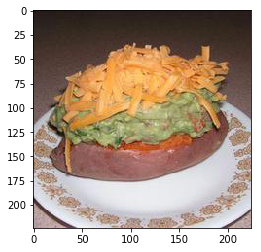

In [17]:
test_img_path = 'food_images/cid11_max2048/2/6848.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [29]:
with tf.Session(graph=graph) as sess:
    
    image_data = gfile.FastGFile(test_img_path, 'rb').read()
    resized_input_values = sess.run(decoded_image_tensor,
                                  {jpeg_data_tensor: image_data})

    feed_dict = {resized_image_tensor: resized_input_values}
    code = sess.run(bottleneck_tensor, feed_dict=feed_dict) 
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


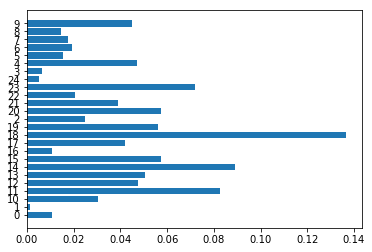

In [31]:
plt.barh(np.arange(len(lb.classes_)), prediction)
_ = plt.yticks(np.arange(len(lb.classes_)), lb.classes_)

In [22]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    predictions = sess.run(predicted, feed_dict=feed)

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


In [23]:
print (predictions.shape)
print(labels[test_idx])
print(np.argmax(test_y, 1).shape)

(4791, 25)
['16' '5' '2' ... '18' '14' '5']
(4791,)


Normalized confusion matrix


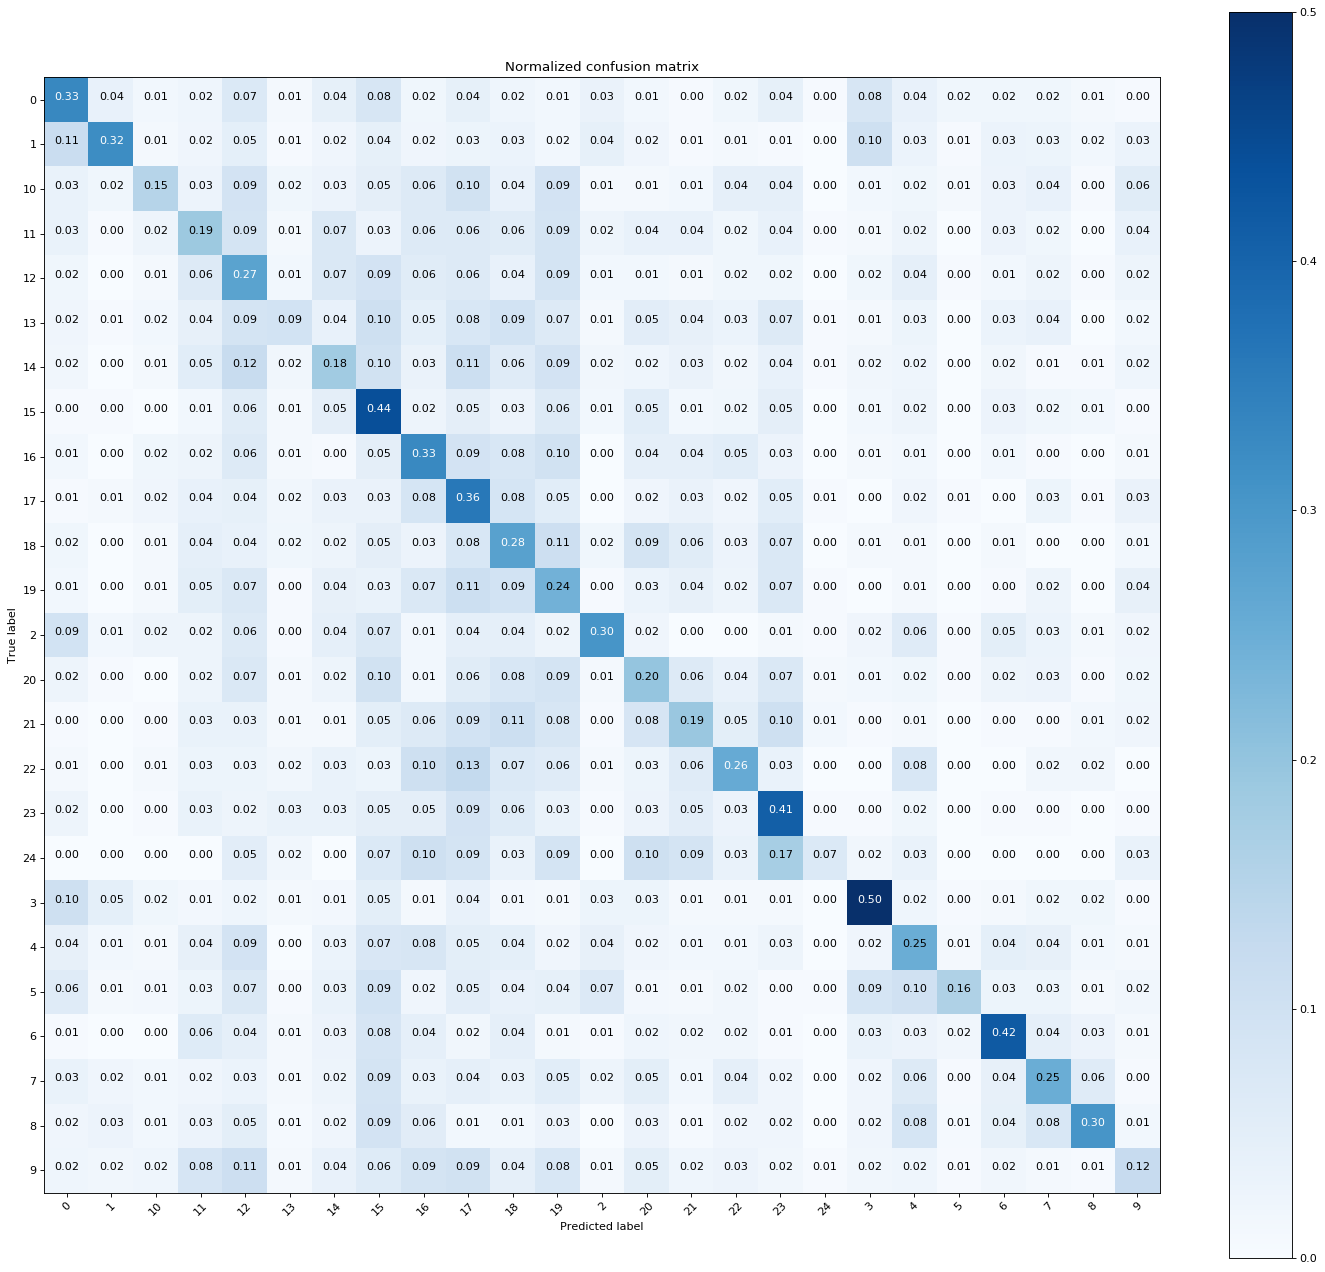

In [24]:
#Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_y, 1), np.argmax(predictions, 1))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=lb.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Save graph

In [82]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    tf.train.write_graph(sess.graph_def, "./", "test.pb", False)